In [7]:
import torch
import librosa
import string
import numpy as np
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from faster_whisper import WhisperModel

def whisper_char_timings(audio_path, model_size="tiny", device="cuda"):
    chinese_punctuation = "，。！？；：「」『』（）【】《》〈〉、"
    all_punctuation = string.punctuation + chinese_punctuation
    
    model = WhisperModel(model_size, device=device, compute_type="float16")
    segments, info = model.transcribe(audio_path, word_timestamps=True, language="zh")
    
    char_list = []
    for seg in segments:
        for word in seg.words:
            text = word.word.strip()
            if not text:
                continue
            clean_text = ''.join(char for char in text if char not in all_punctuation)
            if not clean_text:
                continue
            
            duration = word.end - word.start
            n_chars = len(clean_text)
            step = duration / n_chars
            
            for i, char in enumerate(clean_text):
                onset = word.start + i * step
                char_duration = step
                char_list.append(onset)
    return char_list

In [13]:
import librosa
from transformers import Wav2Vec2Processor, Wav2Vec2Model
audio_processor = Wav2Vec2Processor.from_pretrained("jonatasgrosman/wav2vec2-large-xlsr-53-chinese-zh-cn")
audio_model = Wav2Vec2Model.from_pretrained("jonatasgrosman/wav2vec2-large-xlsr-53-chinese-zh-cn")

C:\Users\FranR\.conda\envs\neuroimaging\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\FranR\.conda\envs\neuroimaging\Lib\site-packages\transformers\configuration_utils.py:365: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at jonatasgrosman/wav2vec2-large-xlsr-53-chinese-zh-cn and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.or

In [14]:
def wav2vec_embeddings(audio_path, onsets, duration):
    audio_model.to("cuda")
    if isinstance(duration, list):
        durations = duration
    else:
        durations = [duration] * len(onsets)
    
    y, _ = librosa.load(audio_path, sr=16000) # read audio
    
    syllable_embeddings = list()
    for onset, dur in zip(onsets, durations):
        start_sample = int(onset * 16000)
        end_sample = int((onset + dur) * 16000)
        if end_sample > len(y):
            y_seg = y[-int(duration*16000):]
        else:
            y_seg = y[start_sample:end_sample]
        
        if len(y_seg) < int(duration * 16000):
            pad_length = int(duration * 16000) - len(y_seg)
            y_seg = np.pad(y_seg, (0, pad_length), mode='constant')
            
        y_seg = torch.from_numpy(y_seg).float().to("cuda")
        
        inputs = audio_processor(
            y_seg, 
            sampling_rate=16000, 
            return_tensors="pt", 
            padding=True
        ).to("cuda")

        with torch.no_grad():
            outputs = audio_model(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).squeeze().cpu()
        syllable_embeddings.append(embeddings.numpy())
    return np.array(syllable_embeddings)

In [81]:
import gc
import mne
import pandas as pd
import numpy as np

eeg_tsv = "ChineseEEG/sub-01/ses-littleprince/sub-01_ses-littleprince_scans.tsv"
acq_df = pd.read_csv(eeg_tsv, sep="\t")
acq_files = acq_df["filename"]

all_data = list()
all_embedding = list()
for idx, acq in enumerate(acq_files[:2]):
    eeg_data_path = f"ChineseEEG/sub-01/ses-littleprince/{acq}"
    audio_path = f"Audio/A1/audio_{idx}.wav"
    raw_data = mne.io.read_raw_brainvision(eeg_data_path, preload=True, verbose=False)
    data_array = raw_data.get_data()
    sfreq = raw_data.info['sfreq']
    events, event_dict = mne.events_from_annotations(raw_data, verbose=True)
    first_trigger_sample = events[1, 0]
    first_trigger_time = first_trigger_sample / sfreq
    audio_onset = whisper_char_timings(audio_path=audio_path)
    first_audio_onset = audio_onset[0]
    time_lag = first_trigger_time - first_audio_onset
    eeg_aligned_onsets = [onset + time_lag for onset in audio_onset]
    eeg_segments = []
    valid_indices = []
    for i, onset in enumerate(eeg_aligned_onsets):
        start_sample = int(onset * sfreq)
        end_sample = start_sample + 50

        if end_sample <= data_array.shape[1]:
            eeg_segment = data_array[:, start_sample:end_sample]  # (n_channels, 50)
            eeg_segments.append(eeg_segment)
            valid_indices.append(i)
        else:
            break

    eeg_data = np.stack(eeg_segments)
    all_data.extend(eeg_data)
    valid_audio_onsets = [audio_onset[i] for i in valid_indices]
    embedding = whisper_embeddings(audio_path=audio_path, onsets=valid_audio_onsets, duration=0.2)
    all_embedding.extend(embedding)
    gc.collect()

all_data = np.array(all_data, dtype=np.float16)
all_embedding = np.array(all_embedding, dtype=np.float16)  # 转换为 np.float16

Used Annotations descriptions: ['Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4']


TypeError: WhisperModel.__init__() got an unexpected keyword argument 'device'

In [53]:
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from math import atanh
from sklearn.decomposition import PCA

def encoding_model(eeg_data, embedding, split_ratio):
    n_tokens, n_channels, n_timepoints = eeg_data.shape
    assert embedding.shape[0] == n_tokens, "Number of tokens must match between EEG data and embeddings"
    
    # 使用PCA降维
    pca = PCA(n_components=50)
    embeddings_pca = pca.fit_transform(embedding)
    
    # 分割数据
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings_pca, eeg_data, test_size=1-split_ratio, random_state=42
    )
    
    alphas = np.logspace(-3, 3, 7)
    channel_correlations = np.zeros(n_channels)
    
    for channel_idx in range(n_channels):
        # 获取当前通道的所有时间点数据
        y_train_channel = y_train[:, channel_idx, :]
        y_test_channel = y_test[:, channel_idx, :]
        
        # 展平时间维度 (n_samples, n_timepoints)
        y_train_flat = y_train_channel.reshape(y_train_channel.shape[0], -1)
        y_test_flat = y_test_channel.reshape(y_test_channel.shape[0], -1)
        
        # 训练Ridge回归模型
        ridge = RidgeCV(alphas=alphas, store_cv_results=True)
        ridge.fit(X_train, y_train_flat)
        
        # 预测
        y_pred_flat = ridge.predict(X_test)
        
        # 将真实值和预测值展平为1D数组，计算整个通道的相关系数
        y_test_1d = y_test_flat.flatten()
        y_pred_1d = y_pred_flat.flatten()
        
        # 计算Pearson相关系数
        r, _ = pearsonr(y_test_1d, y_pred_1d)
        
        # Fisher Z变换（保持与Huth方法一致）
        if abs(r) >= 0.999:
            r = np.sign(r) * 0.999
        fisher_z = atanh(r)
        
        channel_correlations[channel_idx] = r
    
    return channel_correlations

In [78]:
acc = encoding_model(eeg_data = all_data, embedding= all_embedding, split_ratio=0.8)

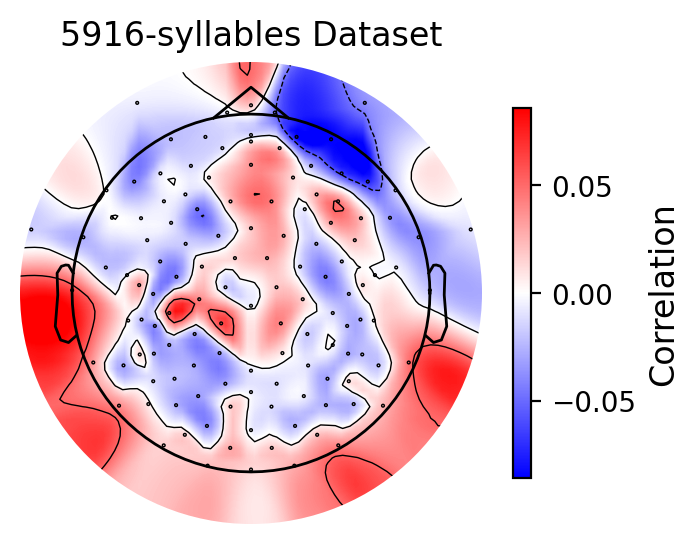

In [79]:
import pickle
info = pickle.load(open("info.pkl","rb"))
import mne.viz
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "retina"

fig, ax = plt.subplots(figsize=(4, 3))
im = mne.viz.plot_topomap(acc, info, ch_type='eeg', show=False, extrapolate="head", 
                         size=1.5, contours=3, cmap="bwr", axes=ax,
                         mask_params=dict(marker='o', markerfacecolor='k', 
                                         markeredgecolor='k', linewidth=0, markersize=6))
cbar = plt.colorbar(im[0], ax=ax, shrink=0.8)
cbar.set_label('Correlation', fontsize=12)
ax.set_title(f"{all_data.shape[0]}-syllables Dataset")

plt.show()